In [1]:
import pandas as pd
import math
import numpy as np

In [2]:
data = pd.read_csv('./주가 데이터 10년/total.csv', encoding = "cp949")

In [3]:
data.head()

,Unnamed: 0,종목코드,종목명,날짜,종가,증권전산업종코드,발행주식수
0,0.0,A060310,3S,20210813,3520,270,46271000
1,1.0,A060310,3S,20210812,3685,270,46271000
2,2.0,A060310,3S,20210811,3590,270,46271000
3,3.0,A060310,3S,20210810,3675,270,46271000
4,4.0,A060310,3S,20210809,3730,270,46271000


In [4]:
b1 = data.loc[: ,'종목명'] == '삼성전자'
b2 = data.loc[: ,'종목명'] == 'AJ네트웍스'
b3 = data.loc[: ,'종목명'] == '희림'

In [5]:
data.loc[: ,'종목명'].unique()

array(['3S', '종목명', 'AJ네트웍스', ..., '흥아해운', '희림', '힘스'], dtype=object)

In [6]:
Price1 = data.loc[b1, "날짜": "종가"]
Price2 = data.loc[b2, "날짜": "종가"]
Price3 = data.loc[b3, "날짜": "종가"]

In [8]:
cntnsYield1 = [] # 연속 수익률
for i in range(len(Price1)-1):
    cntnsYield1.append(math.log(int(Price1.iloc[i, 1]) / int(Price1.iloc[i+1, 1])))
    
    
cntnsYield2 = [] # 연속 수익률
for i in range(len(Price2)-1):
    cntnsYield2.append(math.log(int(Price2.iloc[i, 1]) / int(Price2.iloc[i+1, 1])))
    
    
cntnsYield3 = [] # 연속 수익률
for i in range(len(Price3)-1):
    cntnsYield3.append(math.log(int(Price3.iloc[i, 1]) / int(Price3.iloc[i+1, 1])))

In [9]:
ramda = 0.94 # 람다계수 일별수익률은 0.94사용, 월별은 0.97사용 

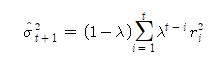

In [10]:
EWMAvariance1 = [] # 지수가주이동평균 분산1
EWMAvariance2 = [] # 지수가주이동평균 분산2
EWMAvariance3 = [] # 지수가주이동평균 분산3

for i in range(len(cntnsYield1), -1, -1):
    sum1 = []
    for j in range(i):
        sum1.append(ramda ** (j) * (cntnsYield1[j] ** 2))
    EWMAvariance1.append((1-ramda) * sum(sum1))
    
for i in range(len(cntnsYield2), -1, -1):
    sum2 = []
    for j in range(i):
        sum2.append(ramda ** (j) * (cntnsYield2[j] ** 2))
    EWMAvariance2.append((1-ramda) * sum(sum2))
    
for i in range(len(cntnsYield3), -1, -1):
    sum3 = []
    for j in range(i):
        sum3.append(ramda ** (j) * (cntnsYield3[j] ** 2))
    EWMAvariance3.append((1-ramda) * sum(sum3))

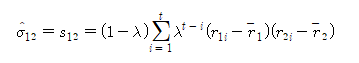

In [79]:
EWMAcov12 = [] # 지수가중 공분산12
EWMAcov13 = [] # 지수가중 공분산13
EWMAcov23 = [] # 지수가중 공분산23

for i in range(len(cntnsYield1), -1, -1):
    sum1 = []
    for j in range(len(cntnsYield1)-1, len(cntnsYield1)-i, -1):
        sum1.append(ramda ** (j) * (cntnsYield1[j] - np.mean(cntnsYield1)*(cntnsYield2[j] - np.mean(cntnsYield2))))
    EWMAcov12.append((1-ramda) * sum(sum1))
    
for i in range(len(cntnsYield1), -1, -1):
    sum2 = []
    for j in range(len(cntnsYield1)-1, len(cntnsYield1)-i, -1):
        sum2.append(ramda ** (j) * (cntnsYield1[j] - np.mean(cntnsYield1)*(cntnsYield3[j] - np.mean(cntnsYield3))))
    EWMAcov13.append((1-ramda) * sum(sum2))
    
for i in range(len(cntnsYield3), -1, -1):
    sum3 = []
    for j in range(len(cntnsYield1)-1, len(cntnsYield1)-i, -1):
        sum3.append(ramda ** (j) * (cntnsYield2[j] - np.mean(cntnsYield2)*(cntnsYield3[j] - np.mean(cntnsYield3))))
    EWMAcov23.append((1-ramda) * sum(sum3))

In [14]:
# 지수가중평균법에 의한 상관계수 추정치
p12 = EWMAcov12[0]/ (EWMAvariance1[0]* EWMAvariance2[0])
p13 = EWMAcov13[0]/ (EWMAvariance1[0]* EWMAvariance3[0])
p23 = EWMAcov23[0]/ (EWMAvariance2[0]* EWMAvariance3[0])

개별 VaR구하기

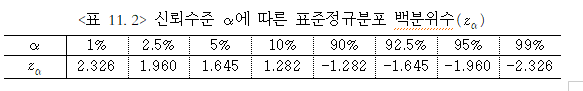

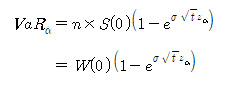

In [68]:
investment = 10000 # 투자금액
Zalpha = -2.326
T = 100 # 투자기간 (일단위)
sigma1 = EWMAvariance1[0] ** 1/2 # 1일 수익률의 변동성으로 지수가중 표준편차 사용
sigma2 = EWMAvariance2[0] ** 1/2
sigma3 = EWMAvariance3[0] ** 1/2

VaR1 = investment * (1- np.exp(Zalpha * sigma1 * (T ** 1/2)))
VaR2 = investment * (1- np.exp(Zalpha * sigma2 * (T ** 1/2)))
VaR3 = investment * (1- np.exp(Zalpha * sigma3 * (T ** 1/2)))

In [69]:
print(VaR1, VaR2, VaR3)

121.05574400728791 343.84275439898414 646.4864222021461


## 포트폴리오 VaR구하기
- 포트폴리오 수익률 구하는 방법은 2가지

    1. 각 주식의 투자비율을 정해서 포트폴리오 수익률 구하기
    2. 포트폴리오 수익률을 정해서 투자비율 구하기

In [18]:
# 각 주식의 투자비율 임의로 지정
w1 = 0.5 # 주식1의 투자비율
w2 = 0.3 # 주식2의 투자비율
w3 = 0.2 # 주식3의 투자비율

# 종목별 수익률은 각 종목의 연속수익률 평균을 사용하였다 -> 이걸 사용하는게 맞는지 모르겠음
r1 = cntnsYield1[0]
r2 = cntnsYield2[0]
r3 = cntnsYield3[0]

Rp = r1 * w1 + r2* w2 + r3* w3# 포트폴리오 수익률

In [19]:
Rp

-0.02374630674658224

In [20]:
# 각 종목별 수익률에 대한 평균과 분산
m1 = np.mean(cntnsYield1[0:T])
m2 = np.mean(cntnsYield2[0:T])
m3 = np.mean(cntnsYield3[0:T])
m = np.array([[m1], [m2], [m3]])

In [89]:
Zalpha = 2.326
investment = 10000 # 투자금액
w = [[w1, w2, w3]]
w = np.array(w)
covMatrix = [[EWMAvariance1[0], EWMAcov12[0], EWMAcov12[0]],
            [EWMAcov12[0], EWMAvariance2[0], EWMAcov23[0]],
            [EWMAcov13[0], EWMAcov23[0], EWMAvariance3[0]]]
Vp = w.dot(covMatrix).dot(w.T) # 포트폴리오 분산

Mp = w.dot(m) # 포트폴리오 수익률의 기대값

In [113]:
Mp

array([[0.00129356]])

### 기간이 t+1시점에서 1기간 일경우

In [90]:
# 신뢰수준 α에서 T+1시점 1기간 포트폴리오 VaR(p)
VaRp = investment * Zalpha * (Vp[0][0] ** 1/2)

In [91]:
VaRp

-10.212642269424709

In [92]:
VaR1 = investment * w1 * Zalpha * (EWMAvariance1[0] ** 1/2)
VaR2 = investment * w2 * Zalpha * (EWMAvariance2[0] ** 1/2)
VaR3 = investment * w3 * Zalpha * (EWMAvariance3[0] ** 1/2)

In [94]:
print(VaR1, VaR2, VaR3)

1.2179443624750637 2.099359474542773 2.6733214624309416


In [95]:
VaRsum = VaR1 + VaR2 + VaR3 # 개별 VaR 합
effect = VaRsum - VaRp  # 분산효과

In [96]:
effect # 분산효과

16.203267568873486

### 기간이  T기간일 경우

In [109]:
investment = 10000 # 투자금액
Zalpha = -2.326
T = 100 # 투자기간 (일단위)
VaR1 = investment* w1 * (1- np.exp(Zalpha * sigma1 * (T ** 1/2)))
VaR2 = investment* w2 * (1- np.exp(Zalpha * sigma2 * (T ** 1/2)))
VaR3 = investment* w3 * (1- np.exp(Zalpha * sigma3 * (T ** 1/2)))

VaRp = investment * (1- np.exp(Zalpha * (Vp[0][0] ** 1/2) * (T ** 1/2)))

In [110]:
print(VaRp, VaR1, VaR2, VaR3)

-523.8941413331144 60.52787200364396 103.15282631969525 129.2972844404292


In [111]:
VaRsum = VaR1 + VaR2 + VaR3 # 개별 VaR 합
effect = VaRsum - VaRp  # 분산효과

In [112]:
effect # 분산효과

816.8721240968828